In [1]:
import pandas as pd
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

%matplotlib inline

from keras import metrics
from keras import layers
from keras import optimizers

import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import np_utils
%tensorflow_version 2.x

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed


from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import History
import copy

import random
sns.set(font_scale=1.2)


Using TensorFlow backend.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
db=arff.loadarff('EES.arff')

In [0]:
df = pd.DataFrame(db[0])
column = pd.to_numeric(df['eyeDetection'])
df = df.drop(['eyeDetection'],axis=1)
df.insert(14,'eyeDetection',column)

In [0]:
#regularize outlier
new_df = np.array(df)
for i in range(len(new_df)):
  for j in range(len(new_df[i])-1):
    if new_df[i][j]>4800:
      new_df[i][j] = new_df[i-1][j]
    if new_df[i][j]<3800:
      new_df[i][j] = new_df[i-1][j]


X_data = new_df[:,0:14]
Y_data = new_df[:,14]


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, TimeDistributed
from keras import optimizers

num_train = 9800
num_test = 4900

X_train = X_data[:num_train,:]
y_train = Y_data[:num_train]
X_test = X_data[num_train:num_train+num_test,:]
y_test = Y_data[num_train:num_train+num_test]

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
feature = 14
time_step = 100
test_batch_size = int(num_test/time_step)
X_test_batch = np.zeros((test_batch_size,time_step,feature))
y_test_batch = np.zeros((test_batch_size,time_step))
for i in range(time_step):
    X_test_batch[:,i,:] = X_test[i*test_batch_size:(i+1)*test_batch_size,:]
    y_test_batch[:,i] = y_test[i*test_batch_size:(i+1)*test_batch_size]
X_te = X_test_batch
y_te = y_test_batch.reshape(y_test_batch.shape[0],y_test_batch.shape[1],1)

In [0]:
#Define function for praparing data
def prepare_data(train_val_ratio,val_size,X_train,y_train,num_train,time_step,feature):
  train_batch_size = int((num_train/time_step)*train_val_ratio)
  train_size = int((num_train)*train_val_ratio)
  X_sub_train = X_train[:train_size,:]
  y_sub_train = y_train[:train_size]
  X_train_batch = np.zeros((train_batch_size,time_step,feature))
  y_train_batch = np.zeros((train_batch_size,time_step))
  for i in range(time_step):
      X_train_batch[:,i,:] = X_sub_train[i*train_batch_size:(i+1)*train_batch_size,:]
      y_train_batch[:,i] = y_sub_train[i*train_batch_size:(i+1)*train_batch_size]
  y_train_batch = y_train_batch.reshape(y_train_batch.shape[0],y_train_batch.shape[1],1)
  val_batch_size = int(val_size/time_step)
  X_val_batch = np.zeros((val_batch_size,time_step,feature))
  y_val_batch = np.zeros((val_batch_size,time_step))
  X_val = X_train[train_size:train_size+val_size,:]
  y_val = y_train[train_size:train_size+val_size]
  for i in range(time_step):
      X_val_batch[:,i,:] = X_val[i*val_batch_size:(i+1)*val_batch_size,:]
      y_val_batch[:,i] = y_val[i*val_batch_size:(i+1)*val_batch_size]
  y_val_batch = y_val_batch.reshape(y_val_batch.shape[0],y_val_batch.shape[1],1)
  return X_train_batch,y_train_batch,X_val_batch,y_val_batch

In [0]:
#define model for training
random.seed(36)
def model_train(batch_size,time_step,feature,X_train,X_val,y_train,y_val):
  model = Sequential()
  model.add(LSTM(128,return_sequences=True,stateful=True,activation = 'tanh',batch_input_shape=(batch_size,time_step,feature)))
  model.add(Dropout(0.2))
  model.add(LSTM(32,return_sequences=True,stateful=True,activation = 'tanh'))
  model.add(TimeDistributed(Dense(1,activation = "sigmoid")))
  adam = optimizers.Adam(lr=0.0001)
  model.compile(optimizer = adam,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  acc=[]
  val_acc=[]
  loss=[]
  val_loss=[]
  best_val_acc = 0
  for i in range(120):
    print('Training on '+str(i+1)+' times')
    history=model.fit(X_train, y_train,epochs=1, batch_size=batch_size,shuffle=False)
    evaluation = model.evaluate(X_val,y_val,49)
    sub_valacc,sub_valloss = evaluation[1],evaluation[0]
    acc.append(history.history['acc'][-1])
    loss.append(history.history['loss'][-1])
    val_acc.append(sub_valacc)
    val_loss.append(sub_valloss)
    print('validation accuracy: '+str(sub_valacc)+'validation loss:'+str(sub_valloss))
    if sub_valacc > best_val_acc:
      weights = model.get_weights()
      best_val_acc = sub_valacc
      index = i
      print('Best model so far')
    model.reset_states()
  return acc,val_acc,loss,val_loss,weights,index

In [0]:
X_tr,y_tr,X_v,y_v=prepare_data(0.5,4900,X_train,y_train,num_train,time_step,feature) #split into validation and train to feed 

In [11]:

acc,val_acc,loss,val_loss,weights,index = model_train(49,100,14,X_tr,X_v,y_tr,y_v) #model train





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Training on 1 times



Epoch 1/1





49/49 [==============================] - 0s 5ms/step
validation accuracy: 0.5330612063407898validation loss:0.6865493059158325
Best model so far
Training on 2 times
Epoch 1/1
49/49 [==============================] - 0s 1ms/step
validation accuracy: 0.5424489974975586validation loss:0.6853245496749878
Best model so far
Training on 3 times
Epoch 1/1
49/49 [==============================] - 0s 1ms/step
validation accuracy: 0.5542857050895691validation loss:0.684211015701294
Best model so far
Training on 4 times
Epoch 1/1
49/49 [==============================] - 0s 1ms/step
validation accuracy: 0.5651020407676697validation loss:0.682880699634552
Best model so far
Training on 5 times
Epoch 1/1
49/49 [==============================] - 0s 1ms/s

In [0]:
#Get the weights for the best model
model = Sequential()
model.add(LSTM(128,return_sequences=True,stateful=True,activation = 'tanh',batch_input_shape=(49,time_step,feature)))
model.add(Dropout(0.2))
model.add(LSTM(32,return_sequences=True,stateful=True,activation = 'tanh'))
model.add(TimeDistributed(Dense(1,activation = "sigmoid")))
sgd = optimizers.Adam(lr=0.0001)
model.compile(optimizer = sgd,
                loss='binary_crossentropy',
                metrics=['accuracy'])

model.set_weights(weights)


In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
p_y_v = model.predict_classes(X_te,49)
t_p_y_v = p_y_v.flatten()
t_y_v = y_te.flatten()
print(accuracy_score(t_p_y_v,t_y_v))
print(f1_score(t_p_y_v,t_y_v))

0.7585714285714286
0.5642725598526704


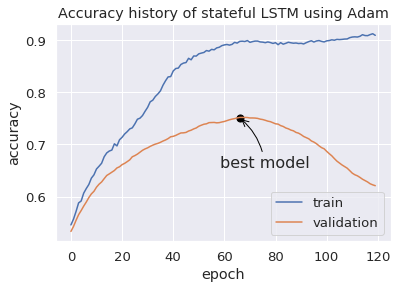

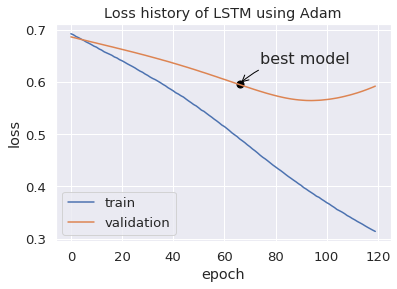

In [24]:
# summarize history for accuracy
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('Accuracy history of stateful LSTM using Adam')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='lower right')
  plt.scatter([index],[val_acc[index-1]], 50, color ='black')
  plt.annotate(r'best model',
             xy=(index, val_acc[index-1]), xycoords='data',
             xytext=(-20, -50), textcoords='offset points', fontsize=16,
             arrowprops=dict(arrowstyle="->", color='black',connectionstyle="arc3,rad=.2"))
  plt.show()
  # summarize history for loss
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Loss history of LSTM using Adam')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='lower left')
  plt.scatter([index],[val_loss[index-1]], 50, color ='black')
  plt.annotate(r'best model',
             xy=(index, val_loss[index-1]), xycoords='data',
             xytext=(20, 20), textcoords='offset points', fontsize=16,
             arrowprops=dict(arrowstyle="->", color='black',connectionstyle="arc3,rad=.2"))
  plt.show()